# HW4 Complete Notebook (Security, Privacy, Fairness)

## Abstract
This notebook is the fully reproducible companion to the HW4 report. It includes complete theoretical foundations, executable methods for Q1/Q2/Q3, bonus fairness methods, artifact checks, and optional report rebuild commands. The default mode is optimized for fast verification by reusing generated report artifacts, while optional toggles allow full recomputation.


## Coverage Map (Paper-Complete Structure)
- Introduction and objective
- Complete theory (security/privacy/fairness)
- Methods and implementation mapping
- Q1 results (Neural Cleanse + unlearning)
- Q2 results (Laplace scenarios + sweeps)
- Q3 results (baseline + assignment + bonus)
- Consolidated artifact/report checks
- Conclusion
- Appendix A-C (extended derivations)


In [1]:
# Setup: imports, paths, and deterministic seeds
from __future__ import annotations

import json
import math
import os
import random

# Runtime hygiene for reproducible/quiet local execution.
os.environ.setdefault('MPLCONFIGDIR', '/tmp/matplotlib')
os.environ.setdefault('LOKY_MAX_CPU_COUNT', '4')
import subprocess
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown

# Make local modules importable even if notebook is launched from a different CWD.
CODE_DIR = Path.cwd()
if not (CODE_DIR / 'generate_report_figs.py').exists():
    candidates = [
        Path('/Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/code'),
        Path.cwd(),
    ]
    for c in candidates:
        if (c / 'generate_report_figs.py').exists():
            CODE_DIR = c
            break
ROOT_DIR = CODE_DIR.parent
REPORT_DIR = ROOT_DIR / 'report'
FIG_DIR = REPORT_DIR / 'figures'
RESULTS_DIR = REPORT_DIR / 'results'

if str(CODE_DIR) not in sys.path:
    sys.path.insert(0, str(CODE_DIR))

SEED = 0
np.random.seed(SEED)
random.seed(SEED)

print('CODE_DIR   =', CODE_DIR)
print('REPORT_DIR =', REPORT_DIR)
print('SEED       =', SEED)


CODE_DIR   = /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/code
REPORT_DIR = /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report
SEED       = 0


In [2]:
# Runtime configuration (optimized defaults)
STUDENT_ID = '810101504'
MODEL_INDEX = None
SECURITY_PROFILE = 'balanced'  # fast-smoke | balanced | high-fidelity
SWAP_K = 10
POPULATION_N = 500
UNBOUNDED_P = 0.01

# Optimized by default: reuse existing artifacts unless explicitly recomputing.
RUN_FULL_PIPELINE = False
RUN_SECURITY_RECOMPUTE = False
RUN_BUILD_PDF = False

EXPECTED_FIGURES = [
    'trigger_reconstructed.png',
    'trigger_all_labels_grid.png',
    'security_scale_profile.png',
    'security_before_after.png',
    'security_confusion_before_after.png',
    'security_unlearning_sweep.png',
    'privacy_scenarios.png',
    'privacy_tail_curves.png',
    'privacy_epsilon_sweep.png',
    'fairness_comparison.png',
    'fairness_group_rates.png',
    'fairness_tradeoff.png',
    'fairness_swapk_sweep.png',
]


## Optional: Regenerate All Artifacts (Q1/Q2/Q3 + macros)
Set `RUN_FULL_PIPELINE = True` above if you want fresh artifacts. This runs the same orchestrator used by the report.


In [3]:
if RUN_FULL_PIPELINE:
    cmd = [
        sys.executable,
        str(CODE_DIR / 'generate_report_figs.py'),
        '--student-id', STUDENT_ID,
        '--security-profile', SECURITY_PROFILE,
        '--swap-k', str(SWAP_K),
        '--population-n', str(POPULATION_N),
        '--unbounded-p', str(UNBOUNDED_P),
        '--seed', str(SEED),
        '--no-download-mnist',
    ]
    print('Running:', ' '.join(cmd))
    subprocess.run(cmd, check=True, cwd=str(CODE_DIR))
    print('Pipeline completed.')
else:
    print('Skipped full regeneration (RUN_FULL_PIPELINE=False). Using cached artifacts/results.')


Skipped full regeneration (RUN_FULL_PIPELINE=False). Using cached artifacts/results.


In [4]:
# Load generated metrics summary (single source of truth for report values)
metrics_path = RESULTS_DIR / 'metrics_summary.json'
if not metrics_path.exists():
    raise FileNotFoundError(f'Missing metrics file: {metrics_path}. Run pipeline generation first.')

metrics = json.loads(metrics_path.read_text(encoding='utf-8'))
print('Loaded metrics from:', metrics_path)
print('Top-level keys:', list(metrics.keys()))


Loaded metrics from: /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report/results/metrics_summary.json
Top-level keys: ['config', 'fairness', 'figures', 'privacy', 'security']


## Introduction
HW4 is a joint trustworthiness study with three objectives: security robustness against backdoors, privacy-preserving query release under DP, and fairness-aware decision behavior across sensitive groups. The notebook keeps those views synchronized in one reproducible pipeline.


## Complete Theory (Quick Reference)
### Security (Backdoor + Neural Cleanse)
- Trigger injection: $\mathcal{T}(x;m,p) = (1-m)\odot x + m\odot p$
- Per-label reconstruction:
  $$\min_{m,p}\;\mathbb{E}_{x}\left[\ell(f_	heta(\mathcal{T}(x;m,p)),y)
ight] + \lambda_1\lVert m
Vert_1 + \lambda_2\lVert p
Vert_1$$
- Detection: lower-tail MAD outlier on reconstructed scales.

### Privacy (Laplace DP)
- Mechanism: $	ilde{q}(D)=q(D)+\eta,\;\eta\sim\mathrm{Lap}(0,b),\;b=\Delta f/\epsilon$
- Threshold tail: $\Pr(	ilde{q}>t)=1-F_{\mathrm{Lap}}(t-q(D);0,b)$
- Sequential composition lock: $\epsilon_i=\epsilon/k,\;\delta_i=\delta/k$
- Unbounded adjacency lock: $\Delta f_{	ext{unbounded}}=\max(1,\lceil pn
ceil)\Delta f$

### Fairness (Metrics + Mitigation)
- Accuracy: $\Pr(\hat{y}=y)$
- Disparate Impact: $\mathrm{DI}=\Pr(\hat{y}=1|s=0)/\Pr(\hat{y}=1|s=1)$
- Reweighing: $w(s,y)=
rac{P(s)P(y)}{P(s,y)}$
- Group-threshold optimization minimizes fairness gap with bounded utility loss.


## Q1 — Security: Neural Cleanse + Unlearning

In [5]:
# Q1 summary table from generated results
sec = metrics.get('security', {})
if 'error' in sec:
    raise RuntimeError(f"Security pipeline error recorded in metrics_summary.json: {sec['error']}")

security_view = {
    'checkpoint_path': sec.get('checkpoint_path'),
    'detected_attacked_label': sec.get('detected_attacked_label'),
    'expected_attacked_label': sec.get('expected_attacked_label'),
    'clean_accuracy_before': sec.get('clean_accuracy_before'),
    'clean_accuracy_after': sec.get('clean_accuracy_after'),
    'asr_before': sec.get('asr_before'),
    'asr_after': sec.get('asr_after'),
    'smallest_scale': sec.get('smallest_scale'),
    'largest_scale': sec.get('largest_scale'),
    'best_fraction_by_asr': sec.get('fraction_sweep', {}).get('best_fraction_by_asr'),
    'best_fraction_asr': sec.get('fraction_sweep', {}).get('best_fraction_asr'),
}

pd.DataFrame([security_view]).T.rename(columns={0: 'value'})


,value
checkpoint_path,/Users/tahamajs/Documents/uni/truthlyAI/HomeWo...
detected_attacked_label,4
expected_attacked_label,4
clean_accuracy_before,0.3518
clean_accuracy_after,0.9637
asr_before,0.994
asr_after,0.1083
smallest_scale,9.812914
largest_scale,178.723999
best_fraction_by_asr,0.2


**trigger_reconstructed.png**

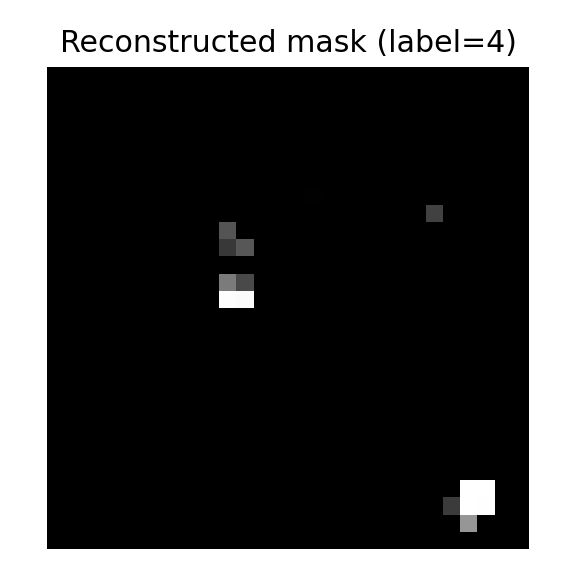

**trigger_all_labels_grid.png**

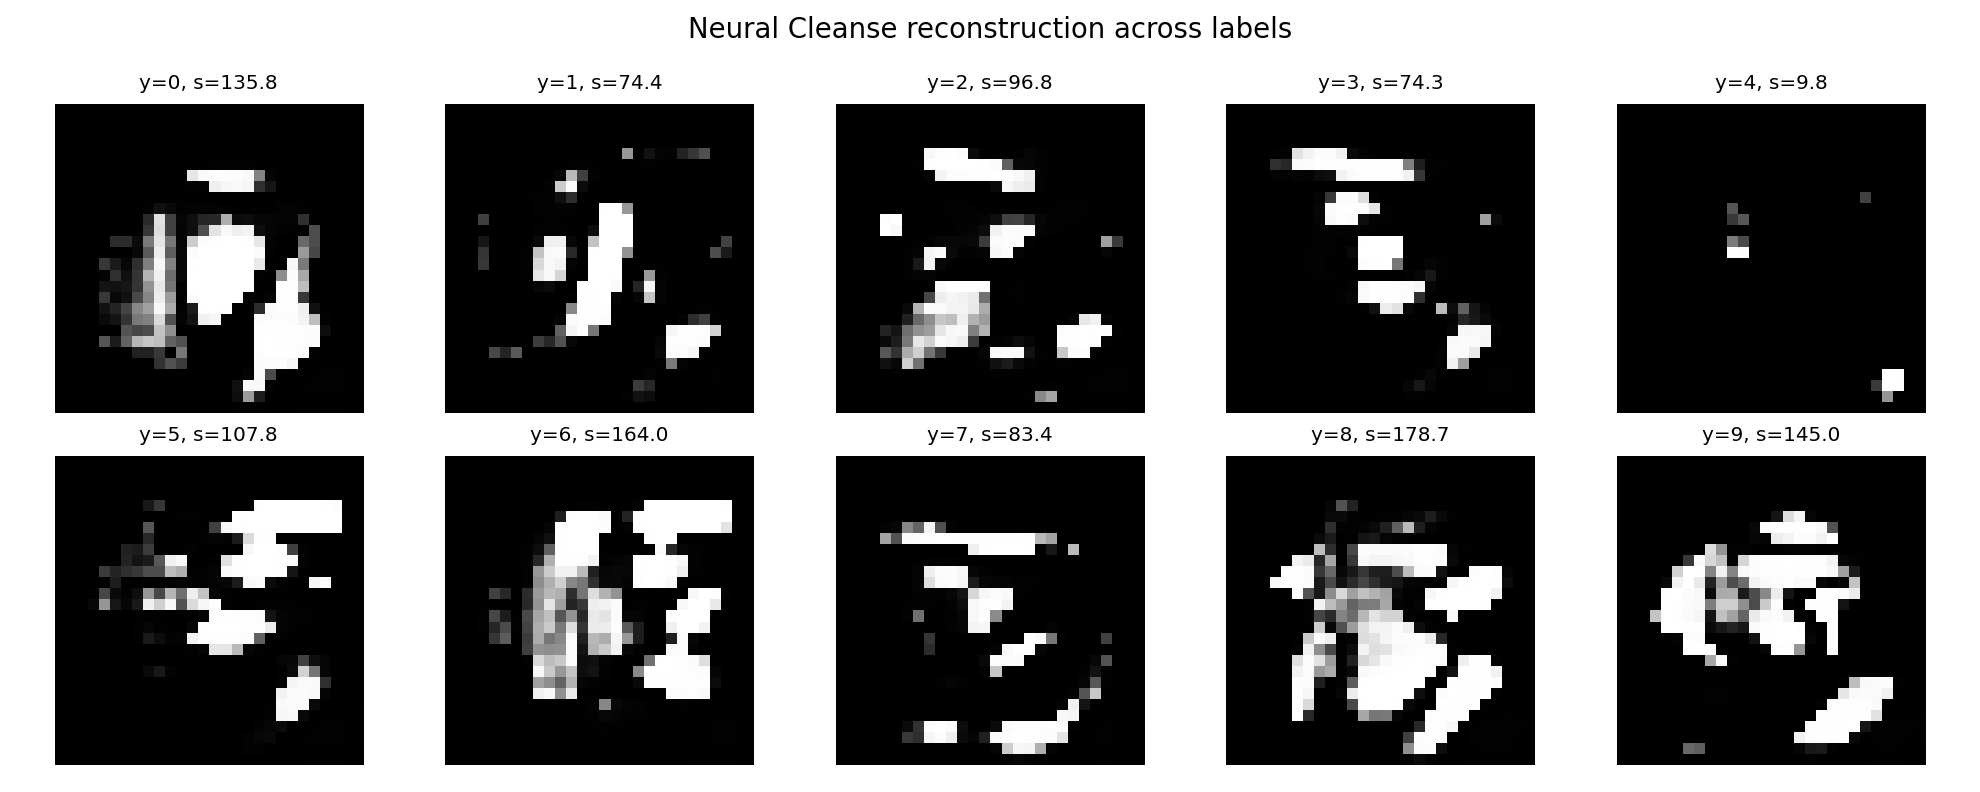

**security_scale_profile.png**

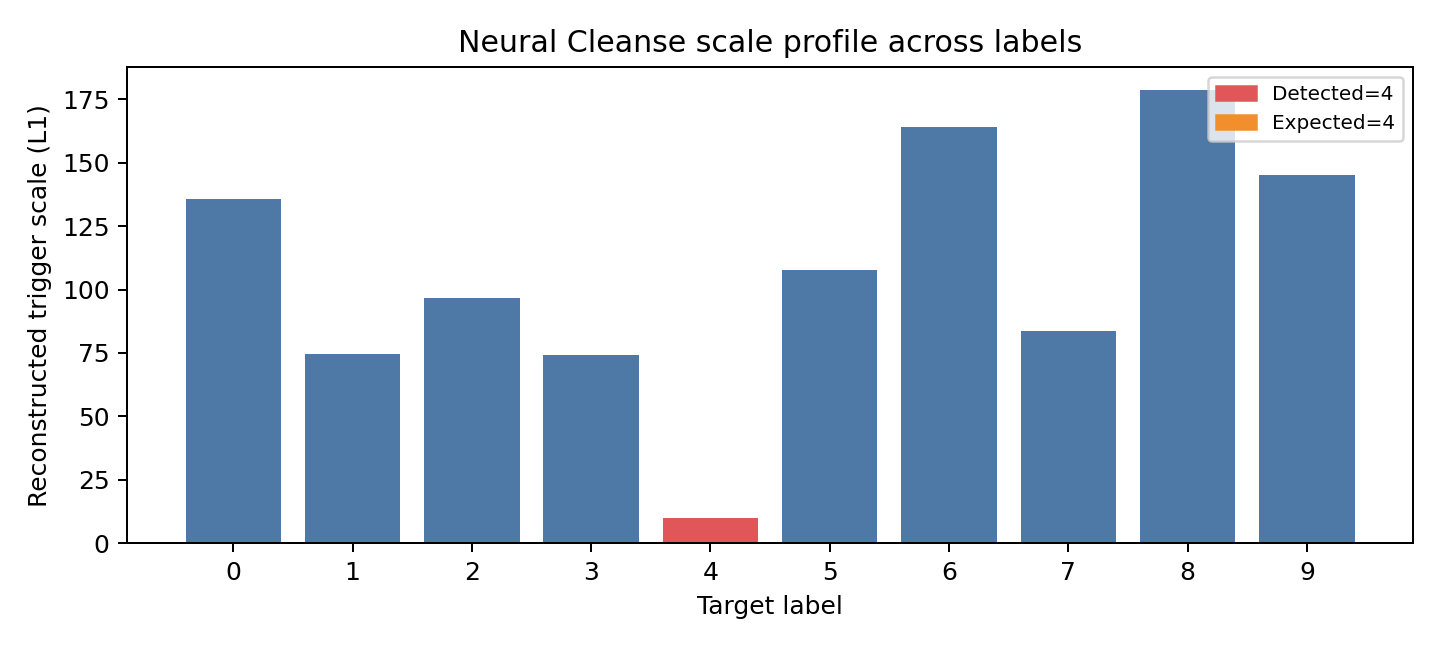

**security_before_after.png**

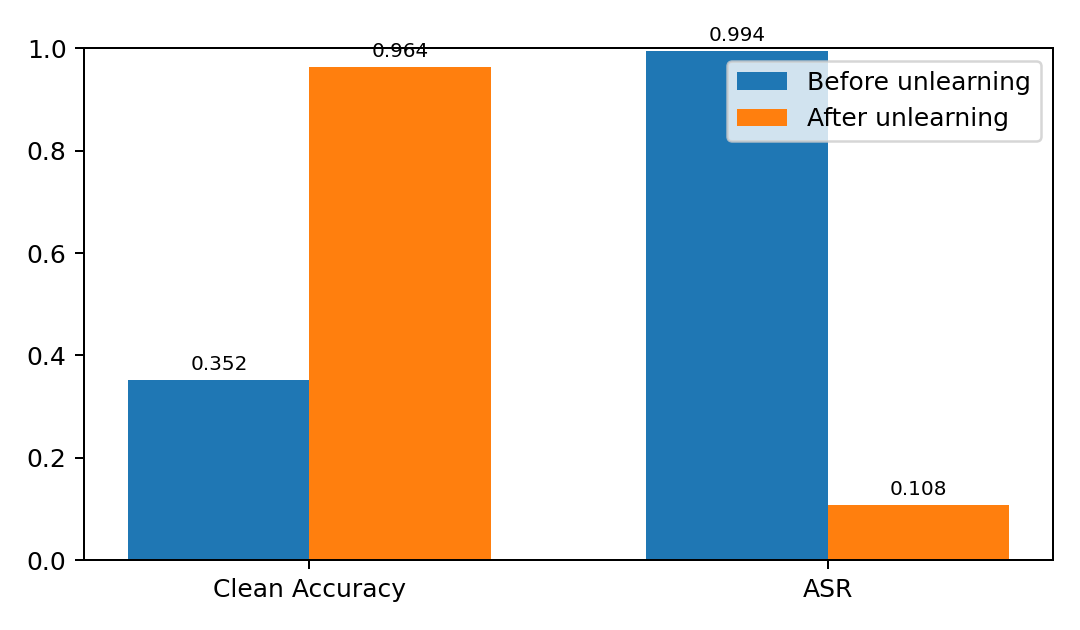

**security_confusion_before_after.png**

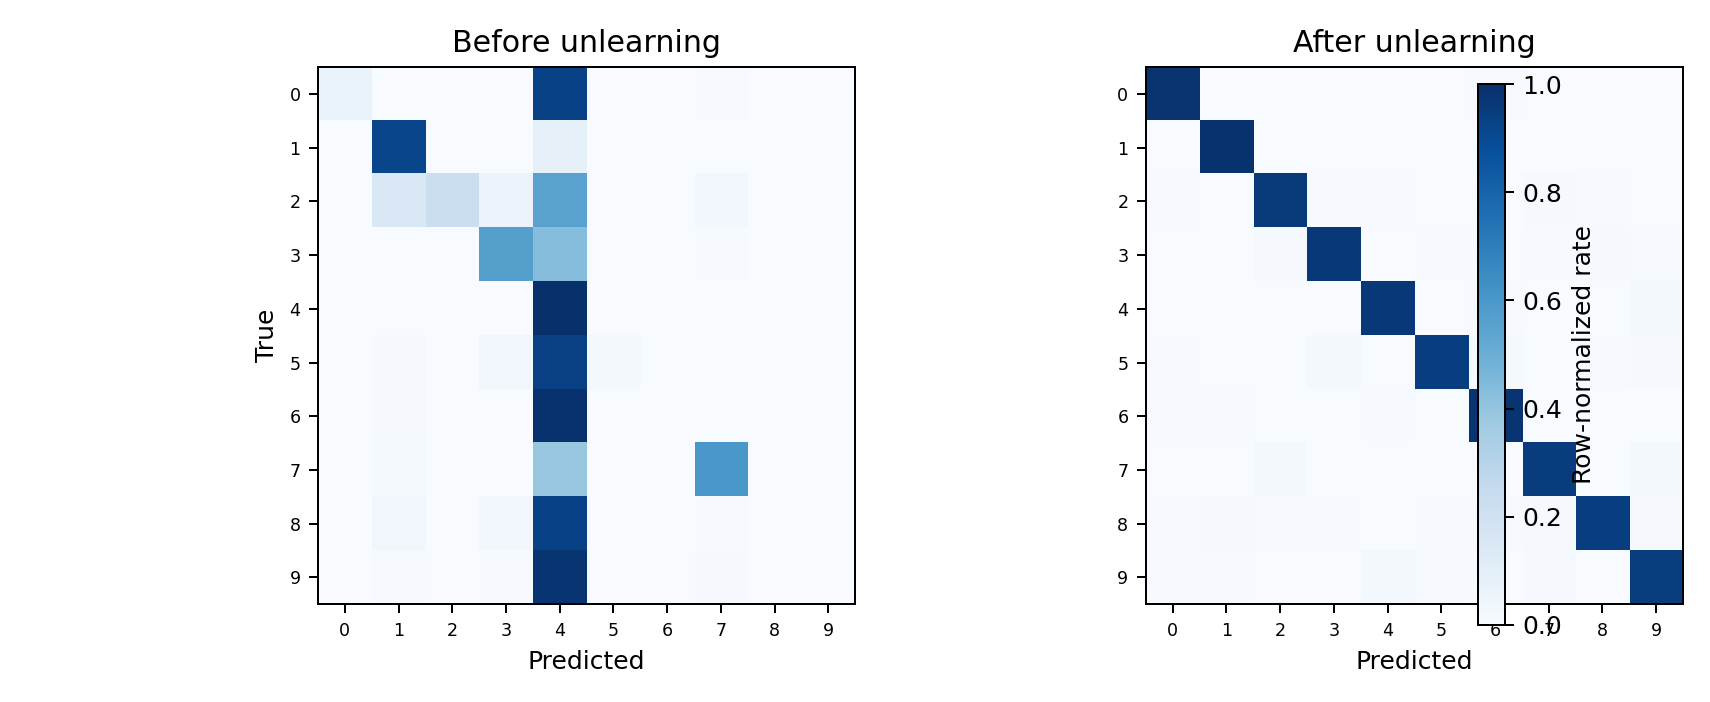

**security_unlearning_sweep.png**

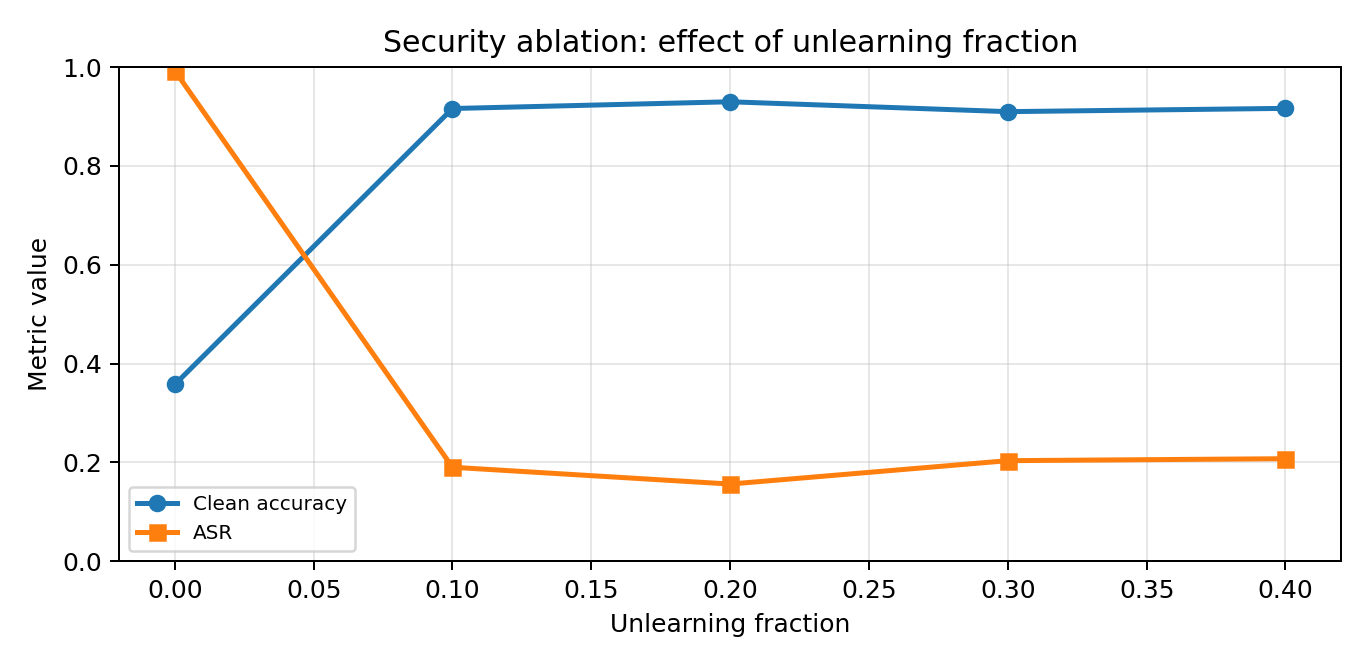

In [6]:
# Display all security figures used in the report
security_figs = [
    'trigger_reconstructed.png',
    'trigger_all_labels_grid.png',
    'security_scale_profile.png',
    'security_before_after.png',
    'security_confusion_before_after.png',
    'security_unlearning_sweep.png',
]
for name in security_figs:
    p = FIG_DIR / name
    if p.exists():
        display(Markdown(f'**{name}**'))
        display(Image(filename=str(p)))
    else:
        print('Missing figure:', p)


In [7]:
# Optional focused recomputation for Q1 only (can be expensive depending on profile)
if RUN_SECURITY_RECOMPUTE:
    from types import SimpleNamespace
    from generate_report_figs import get_paths, configure_seed, run_security

    args = SimpleNamespace(
        student_id=STUDENT_ID,
        model_index=MODEL_INDEX,
        checkpoint_path=None,
        archive_path=None,
        extract_dir=None,
        mnist_root=None,
        download_mnist=False,
        security_profile=SECURITY_PROFILE,
        swap_k=SWAP_K,
        population_n=POPULATION_N,
        unbounded_p=UNBOUNDED_P,
        seed=SEED,
    )
    configure_seed(SEED)
    sec_summary, sec_figs = run_security(args, get_paths())
    print('Recomputed Q1 summary keys:', sorted(sec_summary.keys()))
else:
    print('Skipped Q1 recomputation (RUN_SECURITY_RECOMPUTE=False).')


Skipped Q1 recomputation (RUN_SECURITY_RECOMPUTE=False).


## Q2 — Privacy: Assignment Scenarios + Sweeps

In [8]:
from privacy import income_query_results, counting_query_results, laplace_cdf_threshold

income = income_query_results(
    epsilon=0.1,
    sensitivity_avg=5000.0,
    sensitivity_total=50000.0,
    true_avg=40000.0,
    true_total=20_000_000.0,
    sampled_noise_avg=2000.0,
    sampled_noise_total=5000.0,
    epsilon_avg_split=0.05,
    epsilon_total_split=0.05,
)
counting = counting_query_results(
    epsilon=0.1,
    delta=1e-5,
    sensitivity=1.0,
    true_value=500.0,
    threshold=505.0,
    k=92,
    n=POPULATION_N,
    p=UNBOUNDED_P,
)

print('Income query results:')
display(pd.DataFrame([income]).T.rename(columns={0: 'value'}))
print('Counting query results:')
display(pd.DataFrame([counting]).T.rename(columns={0: 'value'}))


Income query results:


,value
epsilon_total_basic_composition,0.1
b_avg,50000.0
b_total,500000.0
noisy_avg,42000.0
noisy_total,20005000.0
b_avg_split,100000.0
b_total_split,1000000.0
sampled_noise_avg_split,4000.0
sampled_noise_total_split,10000.0
noisy_avg_split,44000.0


Counting query results:


,value
epsilon,1.000000e-01
delta,1.000000e-05
k,9.200000e+01
epsilon_i,1.086957e-03
delta_i,1.086957e-07
b_base,1.000000e+01
prob_base_gt_threshold,3.032653e-01
b_sequential,9.200000e+02
prob_sequential_gt_threshold,4.972900e-01
delta_f_unbounded,5.000000e+00


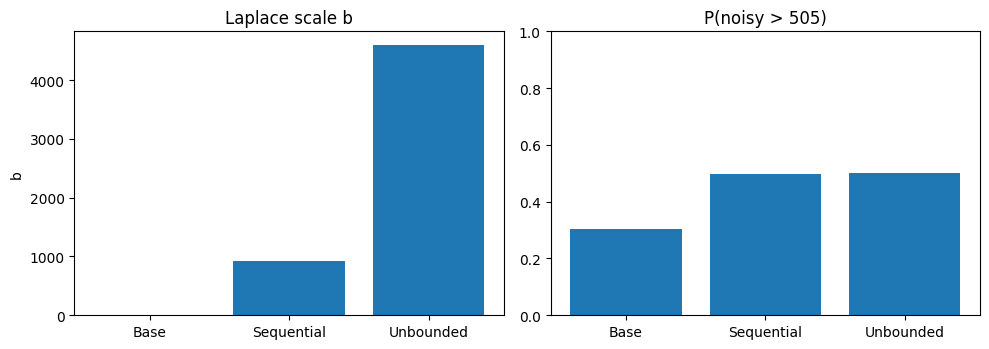

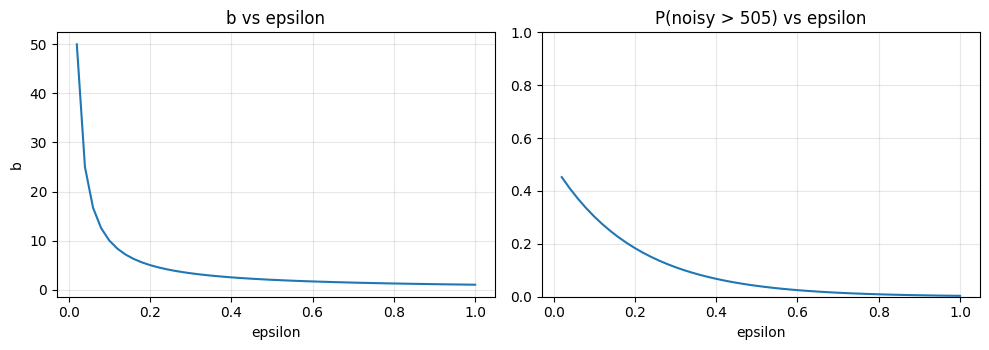

In [9]:
# Notebook-native privacy plots (in addition to report figures)
scenario_names = ['Base', 'Sequential', 'Unbounded']
b_values = [counting['b_base'], counting['b_sequential'], counting['b_unbounded']]
p_values = [
    counting['prob_base_gt_threshold'],
    counting['prob_sequential_gt_threshold'],
    counting['prob_unbounded_gt_threshold'],
]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.6))
axes[0].bar(scenario_names, b_values)
axes[0].set_title('Laplace scale b')
axes[0].set_ylabel('b')

axes[1].bar(scenario_names, p_values)
axes[1].set_title('P(noisy > 505)')
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

eps = np.linspace(0.02, 1.0, 50)
b = [1.0 / e for e in eps]
p_tail = [laplace_cdf_threshold(505.0, 500.0, 1.0, float(e)) for e in eps]

fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))
ax[0].plot(eps, b)
ax[0].set_title('b vs epsilon')
ax[0].set_xlabel('epsilon')
ax[0].set_ylabel('b')
ax[0].grid(alpha=0.3)

ax[1].plot(eps, p_tail)
ax[1].set_title('P(noisy > 505) vs epsilon')
ax[1].set_xlabel('epsilon')
ax[1].set_ylim(0, 1)
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Q3 — Fairness: Baseline, Assignment Method, and Bonus Methods

In [10]:
from sklearn.model_selection import train_test_split
from fairness import (
    load_data,
    train_baseline_model,
    apply_promotion_demotion,
    retrain_with_swapped_labels,
    train_reweighed_model,
    optimize_group_thresholds,
    apply_group_thresholds,
    compute_fairness_metrics,
)

Xdf, y = load_data(str(CODE_DIR / 'data.csv'))
y_np = y.to_numpy()
sensitive = Xdf['gender'].to_numpy()

Xnum = Xdf.select_dtypes(include=[np.number])
columns = list(Xnum.columns)
sens_col_idx = columns.index('gender')
X_with_gender = Xnum.to_numpy()

idx_all = np.arange(X_with_gender.shape[0])
idx_train, idx_test = train_test_split(idx_all, test_size=0.3, random_state=0)
X_train = X_with_gender[idx_train]
X_test = X_with_gender[idx_test]
y_train = y_np[idx_train]
y_test = y_np[idx_test]
sens_train = sensitive[idx_train]
sens_test = sensitive[idx_test]

# Baseline
clf_base = train_baseline_model(X_train, y_train)
Xs_train_base = clf_base._scaler.transform(X_train)
Xs_test_base = clf_base._scaler.transform(X_test)
proba_train_base = clf_base.predict_proba(Xs_train_base)[:, 1]
pred_train_base = (proba_train_base >= 0.5).astype(int)
proba_test_base = clf_base.predict_proba(Xs_test_base)[:, 1]
pred_test_base = (proba_test_base >= 0.5).astype(int)

metrics_tbl = {}
metrics_tbl['baseline'] = compute_fairness_metrics(Xs_test_base, y_test, pred_test_base, sens_test)

# Assignment method
swap_mask = apply_promotion_demotion(
    y_proba=proba_train_base,
    y_pred=pred_train_base,
    sensitive=sens_train,
    k=SWAP_K,
)
clf_swap = retrain_with_swapped_labels(X_train, y_train, swap_mask)
Xs_test_swap = clf_swap._scaler.transform(X_test)
pred_test_swap = (clf_swap.predict_proba(Xs_test_swap)[:, 1] >= 0.5).astype(int)
metrics_tbl['promotion_demotion'] = compute_fairness_metrics(Xs_test_swap, y_test, pred_test_swap, sens_test)

# No-gender variant
X_no_gender = np.delete(X_with_gender, sens_col_idx, axis=1)
Xng_train = X_no_gender[idx_train]
Xng_test = X_no_gender[idx_test]
clf_no_gender = train_baseline_model(Xng_train, y_train)
Xngs_test = clf_no_gender._scaler.transform(Xng_test)
pred_no_gender = (clf_no_gender.predict_proba(Xngs_test)[:, 1] >= 0.5).astype(int)
metrics_tbl['no_gender'] = compute_fairness_metrics(Xngs_test, y_test, pred_no_gender, sens_test)

# Bonus 1: Reweighing
clf_rw = train_reweighed_model(X_train, y_train, sens_train)
Xs_test_rw = clf_rw._scaler.transform(X_test)
pred_rw = (clf_rw.predict_proba(Xs_test_rw)[:, 1] >= 0.5).astype(int)
metrics_tbl['reweighed'] = compute_fairness_metrics(Xs_test_rw, y_test, pred_rw, sens_test)

# Bonus 2: Group thresholds
thr = optimize_group_thresholds(y_true=y_train, y_proba=proba_train_base, sensitive=sens_train)
pred_thr = apply_group_thresholds(proba_test_base, sens_test, thr)
metrics_tbl['group_thresholds'] = compute_fairness_metrics(Xs_test_base, y_test, pred_thr, sens_test)
metrics_tbl['group_thresholds']['threshold_group_0'] = float(thr[0])
metrics_tbl['group_thresholds']['threshold_group_1'] = float(thr[1])

fair_df = pd.DataFrame(metrics_tbl).T
fair_df


,accuracy,disparate_impact,zemel_proxy,threshold_group_0,threshold_group_1
baseline,0.821061,0.178465,0.040719,NaN,NaN
promotion_demotion,0.819832,0.155477,0.043829,NaN,NaN
no_gender,0.814509,0.511025,0.019743,NaN,NaN
reweighed,0.814031,0.595994,0.110175,NaN,NaN
group_thresholds,0.799495,1.029174,0.113290,0.175,0.575


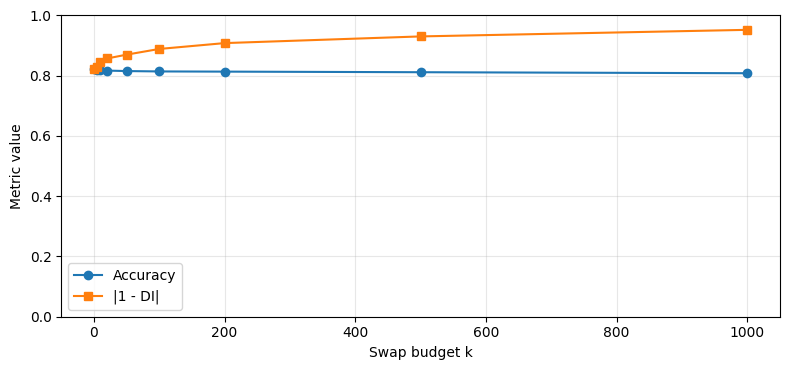

In [11]:
# Fairness ablation: swap budget sweep
k_grid = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
k_grid = [k for k in k_grid if k <= len(y_train)]

k_acc = []
k_gap = []
for k in k_grid:
    if k == 0:
        base_acc = float(metrics_tbl['baseline']['accuracy'])
        base_di = float(metrics_tbl['baseline']['disparate_impact'])
        k_acc.append(base_acc)
        k_gap.append(abs(1.0 - base_di))
        continue
    swap_mask_k = apply_promotion_demotion(proba_train_base, pred_train_base, sens_train, k)
    clf_k = retrain_with_swapped_labels(X_train, y_train, swap_mask_k)
    pred_k = (clf_k.predict_proba(clf_k._scaler.transform(X_test))[:, 1] >= 0.5).astype(int)
    m_k = compute_fairness_metrics(clf_k._scaler.transform(X_test), y_test, pred_k, sens_test)
    k_acc.append(float(m_k['accuracy']))
    k_gap.append(abs(1.0 - float(m_k['disparate_impact'])))

fig, ax = plt.subplots(figsize=(8, 3.8))
ax.plot(k_grid, k_acc, marker='o', label='Accuracy')
ax.plot(k_grid, k_gap, marker='s', label='|1 - DI|')
ax.set_xlabel('Swap budget k')
ax.set_ylabel('Metric value')
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [12]:
# Consistency check against metrics_summary.json (for reproducibility confidence)
report_fair = metrics.get('fairness', {})
rows = []
for key in ['baseline', 'promotion_demotion', 'no_gender', 'reweighed', 'group_thresholds']:
    if key not in metrics_tbl or key not in report_fair:
        continue
    rows.append({
        'model': key,
        'acc_notebook': float(metrics_tbl[key]['accuracy']),
        'acc_report': float(report_fair[key]['accuracy']),
        'di_notebook': float(metrics_tbl[key]['disparate_impact']),
        'di_report': float(report_fair[key]['disparate_impact']),
    })

cmp_df = pd.DataFrame(rows)
if len(cmp_df):
    cmp_df['acc_abs_diff'] = (cmp_df['acc_notebook'] - cmp_df['acc_report']).abs()
    cmp_df['di_abs_diff'] = (cmp_df['di_notebook'] - cmp_df['di_report']).abs()
cmp_df


,model,acc_notebook,acc_report,di_notebook,di_report,acc_abs_diff,di_abs_diff
0,baseline,0.821061,0.821061,0.178465,0.178465,0.0,0.0
1,promotion_demotion,0.819832,0.819832,0.155477,0.155477,0.0,0.0
2,no_gender,0.814509,0.814509,0.511025,0.511025,0.0,0.0
3,reweighed,0.814031,0.814031,0.595994,0.595994,0.0,0.0
4,group_thresholds,0.799495,0.799495,1.029174,1.029174,0.0,0.0


## Artifact Completeness and Report Integration

In [13]:
# Verify all expected report artifacts exist
missing = [name for name in EXPECTED_FIGURES if not (FIG_DIR / name).exists()]
print('Expected figure count:', len(EXPECTED_FIGURES))
print('Missing figures:', missing)

required_files = [
    REPORT_DIR / 'assignment_template.tex',
    REPORT_DIR / 'assignment_template.pdf',
    RESULTS_DIR / 'metrics_summary.json',
    RESULTS_DIR / 'results_macros.tex',
]
for p in required_files:
    print(('OK   ' if p.exists() else 'MISS '), p)


Expected figure count: 13
Missing figures: []
OK    /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report/assignment_template.tex
OK    /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report/assignment_template.pdf
OK    /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report/results/metrics_summary.json
OK    /Users/tahamajs/Documents/uni/truthlyAI/HomeWorks/HW4/report/results/results_macros.tex


In [14]:
# Optional: rebuild IEEE PDF from notebook workflow
if RUN_BUILD_PDF:
    subprocess.run(['make', 'pdf'], check=True, cwd=str(REPORT_DIR))
    print('Rebuilt:', REPORT_DIR / 'assignment_template.pdf')
else:
    print('Skipped PDF rebuild (RUN_BUILD_PDF=False).')


Skipped PDF rebuild (RUN_BUILD_PDF=False).


## Conclusion
This notebook now contains all required assignment parts in one executable workflow and is aligned with the report artifacts. It supports both fast verification (cached artifacts) and full recomputation, while preserving deterministic settings and direct traceability from theory to results.


## Appendix A — Extended Security Theory
Starting from
$$\mathcal{L}_y(m,p)=\mathbb{E}_{x}\left[\ell(f_	heta(\mathcal{T}(x;m,p)),y)
ight]+\lambda_1\|m\|_1+\lambda_2\|p\|_1,$$
we get local trigger sensitivities
$$
rac{\partial \mathcal{T}}{\partial m}=p-x,\qquad 
rac{\partial \mathcal{T}}{\partial p}=m.$$ 
The attacked label tends to minimize perturbation cost, so reconstructed scales $s_y$ are scored with modified z-score
$$z_y=0.6745
rac{s_y-\mathrm{median}(s)}{\mathrm{MAD}(s)}.$$ 
Lower-tail outliers are theoretically correct because true backdoor labels need less perturbation budget.


## Appendix B — Extended Privacy Theory
For $\eta\sim\mathrm{Lap}(0,b)$, the CDF is
$$F_{\mathrm{Lap}}(x;0,b)=egin{cases}
rac{1}{2}e^{x/b},&x<0\1-
rac{1}{2}e^{-x/b},&x\ge 0\end{cases}$$
and threshold tail is
$$\Pr(	ilde q>t)=1-F_{\mathrm{Lap}}(t-q;0,b).$$
Sequential composition fixes per-query budget to $\epsilon_i=\epsilon/k$, so $b$ grows by factor $k$. Under unbounded adjacency, sensitivity scales by $\max(1,\lceil pn
ceil)$, further enlarging $b$ and flattening tail curves.


## Appendix C — Extended Fairness Theory
Promotion/demotion uses prediction cohorts
$$\mathcal{C}_P=\{i:s_i=1,\hat y_i=0\},\qquad \mathcal{C}_D=\{i:s_i=0,\hat y_i=1\}$$
with rank-based label swapping. Reweighing optimizes weighted empirical risk
$$\hat R_w(	heta)=
rac{1}{n}\sum_{i=1}^n w(s_i,y_i)\,\ell(f_	heta(x_i),y_i),\qquad w(s,y)=
rac{P(s)P(y)}{P(s,y)}.$$ 
Group-threshold post-processing solves
$$(	au_0^\*,	au_1^\*)=rg\min_{	au_0,	au_1}\left|1-\mathrm{DI}(	au_0,	au_1)
ight|+\lambda\left(1-\mathrm{Acc}(	au_0,	au_1)
ight).$$
This makes fairness-utility tradeoffs explicit and tunable.
